# Importaciones

In [1]:
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
import matplotlib.pyplot as plt
import joblib

In [2]:
df_pizzas_sd = pd.read_csv(r'Datawarehouse\pizzas_normales_sd.csv')

# Sarima

## Preparación de datos

In [3]:
df_pizzas_sd['fecha'] = pd.to_datetime(df_pizzas_sd['fecha'])  # Convertir a datetime
df_pizzas_sd = df_pizzas_sd.set_index('fecha')  # Establecer la fecha como índice

df_pizzas_sd.index.freq = 'MS'  # 'MS' significa inicio de mes

# Preparar los datos para el modelo ARIMA
y = df_pizzas_sd['unidades_total']

# Dividir los datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
train_size = int(len(y) * 0.8)
train, test = y[0:train_size], y[train_size:]

## Primer Modelo Sarima

In [31]:
# Suprimir advertencias específicas
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [32]:
# Ejemplo de ajuste de modelo SARIMA
order = (1, 1, 1)            # Parámetros (p, d, q) para el componente no estacional
seasonal_order = (1, 1, 1, 12)  # Parámetros (P, D, Q, s) para el componente estacional

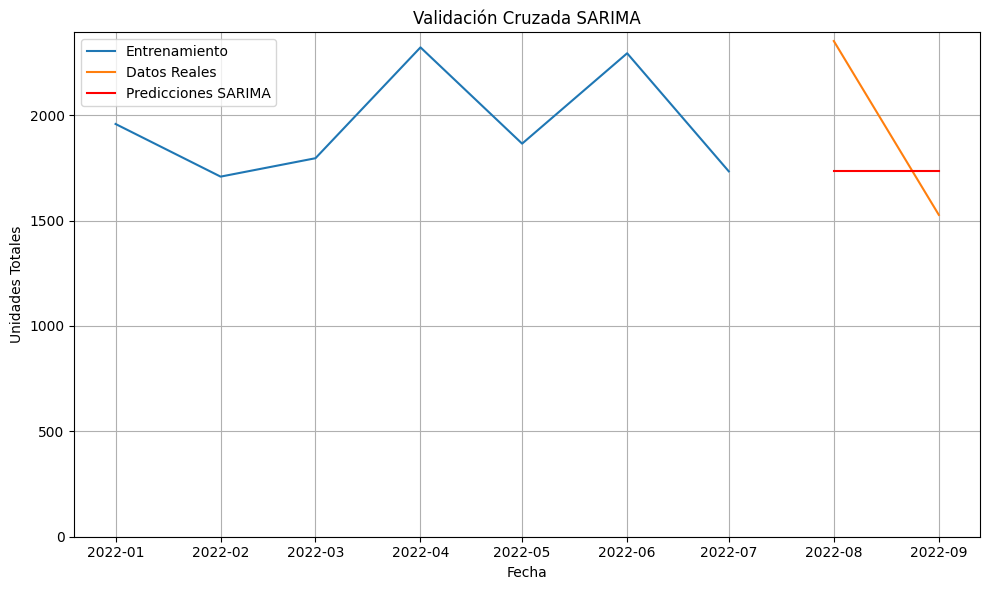

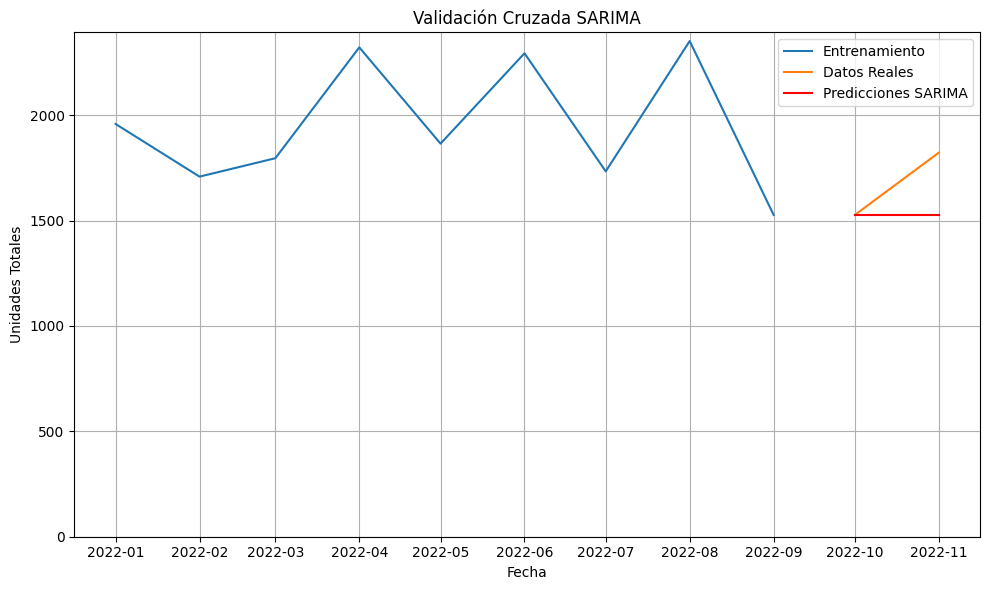

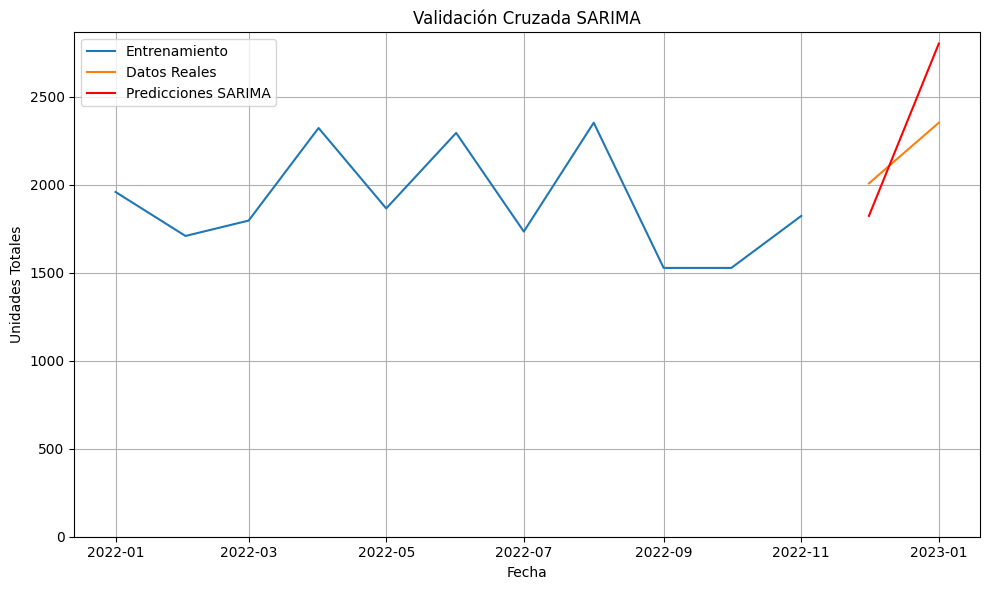

C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


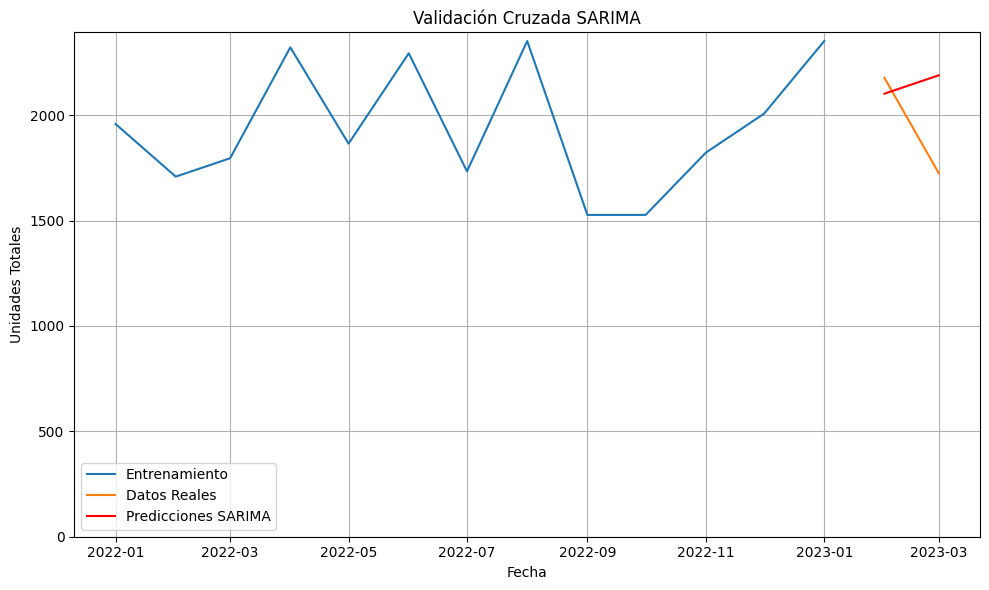

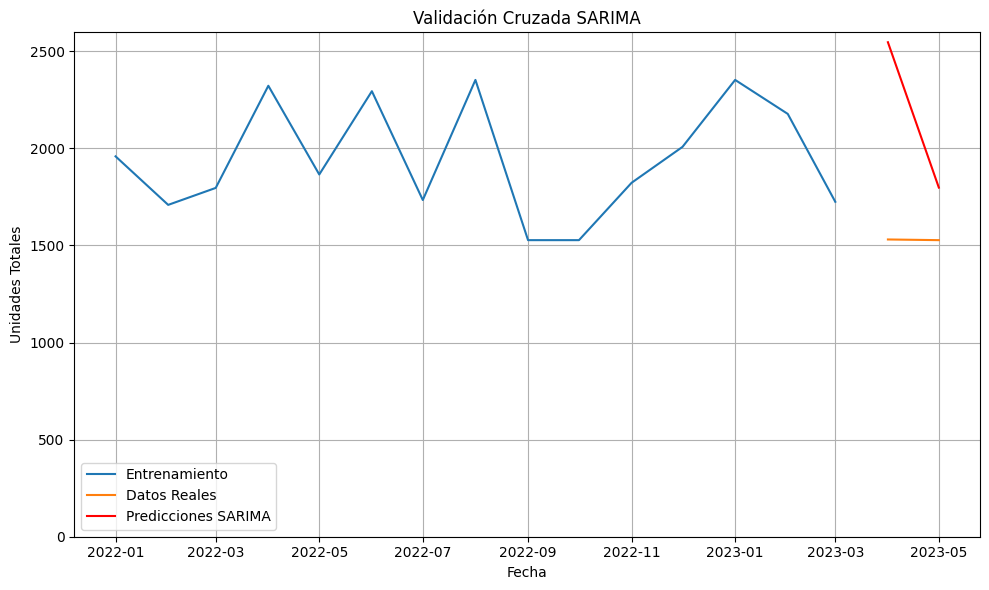

In [33]:
# Crear el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Lista para almacenar los MSE de cada iteración
mse_scores = []

for train_index, test_index in tscv.split(y):
    train, test = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustar el modelo SARIMA
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    
    # Hacer predicciones
    predictions = model_fit.forecast(steps=len(test))
    
    # Calcular el MSE y almacenarlo
    mse = mean_squared_error(test, predictions)
    mse_scores.append(mse)

    # Graficar las predicciones vs datos reales
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Entrenamiento')
    plt.plot(test.index, test, label='Datos Reales')
    plt.plot(test.index, predictions, color='red', label='Predicciones SARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades Totales')
    plt.title('Validación Cruzada SARIMA')
    plt.legend()
    plt.grid(True)
    plt.ylim(0)
    plt.tight_layout()
    plt.show()

In [34]:
# Promediar los resultados de MSE
average_mse_0 = np.mean(mse_scores)
print(f'MSE promedio: {average_mse_0}')

mse_0 = mse_scores[-1]
print(f'MSE: {mse_0}')

square_mse_0 = mse_scores[-1]**2
print(f'MSE square: {square_mse_0}')

MSE promedio: 207504.37857699377
MSE: 552265.9277607988
MSE square: 304997654965.49585


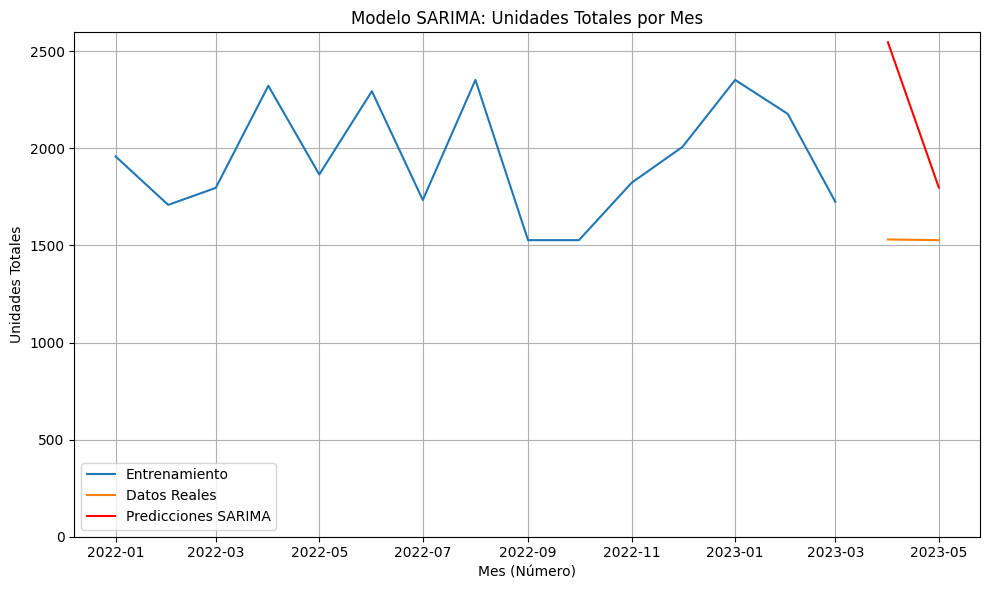

In [35]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Datos Reales')
plt.plot(test.index, predictions, color='red', label='Predicciones SARIMA')

# Personalizar el gráfico
plt.xlabel('Mes (Número)')
plt.ylabel('Unidades Totales')
plt.title('Modelo SARIMA: Unidades Totales por Mes')
plt.legend()

# Agregar una cuadrícula
plt.grid(True)

# Establecer el eje y para que comience desde cero
plt.ylim(0)

plt.tight_layout()
plt.show()

## Hiperparametrización

In [46]:
# Definir los rangos de parámetros a probar
p = range(0, 3)  # Ejemplo: probar órdenes de AR de 0 a 2
d = range(0, 2)  # Ejemplo: probar diferenciaciones de 0 a 1
q = range(0, 3)  # Ejemplo: probar órdenes de MA de 0 a 2
P = range(0, 3)  # Ejemplo: probar órdenes de AR estacional de 0 a 2
D = range(0, 2)  # Ejemplo: probar diferenciaciones estacionales de 0 a 1
Q = range(0, 3)  # Ejemplo: probar órdenes de MA estacional de 0 a 2
s = range(3, 12)         # Ejemplo: frecuencia estacional (por ejemplo, 12 para datos mensuales)

# Generar todas las combinaciones posibles de parámetros
param_combinations = list(product(p, d, q, P, D, Q, s))

best_params_list = []
best_mse_list = []

# Definir la validación cruzada
cv = TimeSeriesSplit(n_splits=7)

# Iterar sobre las combinaciones de parámetros
for params in param_combinations:
    try:
        mse_scores = []
        # Iterar sobre las particiones de la validación cruzada
        for train_index, val_index in cv.split(train):
            train_cv, val_cv = train[train_index], train[val_index]
            
            # Entrenar el modelo con la partición de entrenamiento actual
            model = SARIMAX(train_cv, order=params[:3], seasonal_order=(params[3], params[4], params[5], params[6]))
            results = model.fit(disp=False)
            
            # Predecir sobre la partición de validación
            predictions = results.forecast(steps=len(val_cv))
            mse = mean_squared_error(val_cv, predictions)
            mse_scores.append(mse)
        
        # Calcular el MSE promedio de las particiones de validación
        avg_mse = np.mean(mse_scores)
        
        # Guardar los mejores 10 modelos según el MSE
        if len(best_params_list) < 40:
            best_params_list.append(params)
            best_mse_list.append(avg_mse)
        else:
            # Reemplazar el modelo con el MSE más alto si se encuentra uno mejor
            max_mse_index = np.argmax(best_mse_list)
            if avg_mse < best_mse_list[max_mse_index]:
                best_params_list[max_mse_index] = params
                best_mse_list[max_mse_index] = avg_mse
    
    except Exception as e:
        print(f"Error con los parámetros {params}: {e}")
        continue

C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 0, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 0, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 0, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 1, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (0, 0, 0, 1, 1, 0, 9): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error con los parámetros (0, 0, 0, 1, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (0, 0, 0, 1, 1, 0, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 0, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 0, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 0, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 0, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 2, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (0, 0, 0, 2, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (0, 0, 0, 2, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (0, 0, 0, 2, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 0, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 0, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 0, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 0, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 0, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 1, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 1, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 1, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 2, 0, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 2, 0, 1, 7): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 2, 0, 2, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (0, 0, 1, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 1, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 1, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 1, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 2, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 2, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 2, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 2, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 2, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 2, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 2, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 2, 2, 0, 2, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 2, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py

Error con los parámetros (0, 0, 2, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (0, 0, 2, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 0, 2, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 0, 2, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (0, 0, 2, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 0, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 0, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 0, 7): Schur decomposition solver error.
Error con los parámetros (0, 1, 0, 1, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (0, 1, 0, 1, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (0, 1, 0, 1, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (0, 1, 0, 1, 1, 0, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 0, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 0, 7): Schur decomposition solver error.
Error con los parámetros (0, 1, 0, 2, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (0, 1, 0, 2, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (0, 1, 0, 2, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (0, 1, 0, 2, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 0, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 0, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 0, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 0, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 1, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 1, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 1, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 1, 0, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (0, 1, 1, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 1, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 2, 0, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 2, 0, 2, 5): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (0, 1, 1, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 1, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 1, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 1, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 0, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 2, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 2, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 2, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (0, 1, 2, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 2, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 2, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 2, 0, 2, 8): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py

Error con los parámetros (0, 1, 2, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (0, 1, 2, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (0, 1, 2, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (0, 1, 2, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 0, 1, 0, 8): Input contains NaN.
Error con los parámetros (1, 0, 0, 0, 1, 0, 9): Input contains NaN.
Error con los parámetros (1, 0, 0, 0, 1, 0, 10): Input contains NaN.
Error con los parámetros (1, 0, 0, 0, 1, 0, 11): Input contains NaN.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 0, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 0, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 0, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 0, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 0, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 0, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 0, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 0, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 1, 0, 2, 6): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 1, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 1, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 1, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 1, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 2, 0, 1, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 2, 0, 2, 9): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 2, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 2, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 0, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 0, 2, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (1, 0, 0, 2, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 0, 1, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 1, 0, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 1, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 2, 0, 1, 3): LU decomposition error.
Error con los parámetros (1, 0, 1, 2, 0, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 2, 0, 1, 8): LU decomposition error.
Error con los parámetros (1, 0, 1, 2, 0, 1, 9): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 1, 2, 0, 1, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 1, 2, 0, 1, 11): LU decomposition error.
Error con los parámetros (1, 0, 1, 2, 0, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 1, 2, 0, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 2, 0, 2, 8): LU decomposition error.
Error con los parámetros (1, 0, 1, 2, 0, 2, 9): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 2, 0, 2, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 2, 1, 0, 6): LU decomposition error.
Error con los parámetros (1, 0, 1, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py

Error con los parámetros (1, 0, 1, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 1, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 1, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 1, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 0, 1, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 0, 1, 0, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 0, 2, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 0, 1, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 2, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 1, 0, 1, 8): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 0, 2, 1, 1, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 2, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 2, 2, 0, 0, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 0, 0, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 0, 1, 5): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 0, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 0, 2, 6): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 0, 2, 7): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 0, 2, 8): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 0, 2, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (1, 0, 2, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 1, 1, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 0, 2, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 0, 2, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 0, 2, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (1, 0, 2, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 0, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 0, 1, 0, 7): Input contains NaN.
Error con los parámetros (1, 1, 0, 0, 1, 0, 8): Input contains NaN.
Error con los parámetros (1, 1, 0, 0, 1, 0, 9): Input contains NaN.
Error con los parámetros (1, 1, 0, 0, 1, 0, 10): Input contains NaN.
Error con los parámetros (1, 1, 0, 0, 1, 0, 11): Input contains NaN.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 0, 1, 1, 7): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 0, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 0, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 0, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 0, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 0, 1, 2, 7): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 0, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 0, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 0, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 0, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 1, 1, 0, 7): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 1, 1, 1, 7): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 1, 1, 2, 7): LU decomposition error.
Error con los parámetros (1, 1, 0, 1, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 1, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 2, 0, 1, 6): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 2, 1, 0, 7): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 2, 1, 1, 7): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 0, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 0, 2, 1, 2, 7): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (1, 1, 0, 2, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 0, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 1, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 1, 1, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (1, 1, 1, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 1, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 1, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 2, 0, 2, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 2, 1, 0, 5): LU decomposition error.
Error con los parámetros (1, 1, 1, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py

Error con los parámetros (1, 1, 1, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 1, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 1, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 1, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 1, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 1, 1, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 0, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 0, 1, 1, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 2, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 0, 1, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 2, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (1, 1, 2, 1, 0, 0, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 1, 1, 0, 5): LU decomposition error.
Error con los parámetros (1, 1, 2, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfr

Error con los parámetros (1, 1, 2, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 1, 1, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 1, 1, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 2, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 0, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 0, 1, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 0, 2, 9): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (1, 1, 2, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 1, 1, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 1, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 2, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 1, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (1, 1, 2, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (1, 1, 2, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (1, 1, 2, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 0, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 0, 1, 0, 8): Input contains NaN.
Error con los parámetros (2, 0, 0, 0, 1, 0, 9): Input contains NaN.
Error con los parámetros (2, 0, 0, 0, 1, 0, 10): Input contains NaN.
Error con los parámetros (2, 0, 0, 0, 1, 0, 11): Input contains NaN.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 0, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 0, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 0, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 0, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 0, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 0, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 0, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 0, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 1, 0, 1, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 1, 0, 2, 8): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 1, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 1, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 1, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 1, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 1, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 1, 1, 1, 9): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error con los parámetros (2, 0, 0, 1, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 1, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 1, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 1, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 1, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 1, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 0, 0, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 0, 1, 8): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 0, 1, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 0, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 0, 2, 7): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 0, 2, 8): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 0, 2, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 2, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 2, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 0, 2, 1, 2, 6): LU decomposition error.
Error con los parámetros (2, 0, 0, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 0, 2, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (2, 0, 0, 2, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 0, 1, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 0, 1, 0, 1, 0, 5): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 0, 1, 0, 6): LU decomposition error.
Error con los parámetros (2, 0, 1, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 1, 0, 1, 1, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 0, 1, 1, 5): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 0, 1, 1, 6): LU decomposition error.
Error con los parámetros (2, 0, 1, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 1, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 0, 1, 2, 5): LU decomposition error.
Error con los parámetros (2, 0, 1, 0, 1, 2, 6): LU decomposition error.
Error con los parámetros (2, 0, 1, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 1, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 0, 1, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 1, 0, 0, 7): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 1, 1, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (2, 0, 1, 1, 1, 1, 6): LU decomposition error.
Error con los parámetros (2, 0, 1, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 1, 1, 1, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 0, 1, 1, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 0, 1, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 0, 1, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 0, 2, 6): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 1, 0, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 1, 0, 5): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 0, 1, 2, 1, 0, 6): LU decomposition error.
Error con los parámetros (2, 0, 1, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py

Error con los parámetros (2, 0, 1, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 1, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 0, 1, 2, 1, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 1, 1, 5): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 1, 1, 6): LU decomposition error.
Error con los parámetros (2, 0, 1, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 1, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 1, 2, 5): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 1, 2, 1, 2, 6): LU decomposition error.
Error con los parámetros (2, 0, 1, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 1, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 1, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 0, 0, 1, 6): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 0, 0, 1, 7): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 2, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 0, 2, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 1, 0, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 1, 0, 1, 5): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 1, 0, 2, 9): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py

Error con los parámetros (2, 0, 2, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 0, 2, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 1, 1, 2, 6): LU decomposition error.
Error con los parámetros (2, 0, 2, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 2, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 0, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 0, 0, 8): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 0, 1, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 0, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 0, 2, 9): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 0, 2, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 0, 2, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 1, 0, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 1, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys

Error con los parámetros (2, 0, 2, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 1, 1, 6): LU decomposition error.
Error con los parámetros (2, 0, 2, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 0, 2, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 0, 2, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 0, 2, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 0, 1, 0, 5): LU decomposition error.
Error con los parámetros (2, 1, 0, 0, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 0, 0, 1, 0, 7): Input contains NaN.
Error con los parámetros (2, 1, 0, 0, 1, 0, 8): Input contains NaN.
Error con los parámetros (2, 1, 0, 0, 1, 0, 9): Input contains NaN.
Error con los parámetros (2, 1, 0, 0, 1, 0, 10): Input contains NaN.
Error con los parámetros (2, 1, 0, 0, 1, 0, 11): Input contains NaN.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 0, 1, 1, 5): LU decomposition error.
Error con los parámetros (2, 1, 0, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 0, 0, 1, 1, 7): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 0, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 0, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 0, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 0, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 0, 1, 2, 5): LU decomposition error.
Error con los parámetros (2, 1, 0, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 0, 0, 1, 2, 7): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error con los parámetros (2, 1, 0, 0, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 0, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 0, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 0, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 0, 1, 1, 0, 7): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 0, 11): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 1, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 1, 1, 1, 5): LU decomposition error.
Error con los parámetros (2, 1, 0, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 0, 1, 1, 1, 7): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 1, 1, 2, 5): LU decomposition error.
Error con los parámetros (2, 1, 0, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 0, 1, 1, 2, 7): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error con los parámetros (2, 1, 0, 1, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 1, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 2, 0, 2, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 2, 1, 0, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 0, 2, 1, 0, 7): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 0, 8): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 0, 9): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 0, 10): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 0, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 2, 1, 1, 5): LU decomposition error.
Error con los parámetros (2, 1, 0, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error con los parámetros (2, 1, 0, 2, 1, 1, 7): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 1, 8): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 1, 9): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 1, 10): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 1, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 0, 2, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 1, 0, 2, 1, 2, 5): LU decomposition error.
Error con los parámetros (2, 1, 0, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Error con los parámetros (2, 1, 0, 2, 1, 2, 7): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 2, 8): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 2, 9): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 2, 10): Schur decomposition solver error.
Error con los parámetros (2, 1, 0, 2, 1, 2, 11): Schur decomposition solver error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 0, 1, 0, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 0, 1, 0, 5): LU decomposition error.
Error con los parámetros (2, 1, 1, 0, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 1, 1, 0, 1, 1, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 1, 1, 0, 1, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 0, 1, 1, 5): LU decomposition error.
Error con los parámetros (2, 1, 1, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 0, 1, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 0, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 0, 1, 2, 5): LU decomposition error.
Error con los parámetros (2, 1, 1, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 0, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 0, 0, 6): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 0, 0, 9): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 0, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 0, 1, 8): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 0, 1, 10): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 0, 2, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 1, 0, 5): LU decomposition error.
Error con los parámetros (2, 1, 1, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (2, 1, 1, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (2, 1, 1, 1, 1, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 1, 1, 1, 1, 1, 5): LU decomposition error.
Error con los parámetros (2, 1, 1, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 1, 1, 2, 5): LU decomposition error.
Error con los parámetros (2, 1, 1, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 2, 0, 0, 7): LU decomposition error.
Error con los parámetros (2, 1, 1, 2, 0, 0, 8): LU decomposition error.
Error con los parámetros (2, 1, 1, 2, 0, 0, 9): LU decomposition error.
Error con los parámetros (2, 1, 1, 2, 0, 0, 10): LU decomposition error.
Error con los parámetros (2, 1, 1, 2, 0, 0, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 2, 0, 1, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 2, 0, 2, 11): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (2, 1, 1, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 2, 1, 1, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 2, 1, 1, 5): LU decomposition error.
Error con los parámetros (2, 1, 1, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 1, 1, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 1, 1, 2, 1, 2, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 2, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 1, 2, 1, 2, 5): LU decomposition error.
Error con los parámetros (2, 1, 1, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 1, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 1, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 0, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 0, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 0, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 2, 0, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 0, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 0, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 0, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 0, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 1, 2, 1, 0, 0, 3): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


Error con los parámetros (2, 1, 2, 1, 0, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 1, 0, 1, 6): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 1, 1, 0, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 1, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (2, 1, 2, 1, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 1, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 2, 1, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 2, 1, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 1, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 1, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 2, 1, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 1, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 2, 0, 1, 9): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 2, 0, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 2, 1, 0, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 0, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 0, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 0, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (2, 1, 2, 2, 1, 0, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2k

Error con los parámetros (2, 1, 2, 2, 1, 0, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 2, 1, 1, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 1, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 1, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 1, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 2, 2, 1, 1, 10): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 2, 2, 1, 1, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 2, 1, 2, 4): LU decomposition error.


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `se

Error con los parámetros (2, 1, 2, 2, 1, 2, 6): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 2, 7): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 2, 8): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 2, 9): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\Ap

Error con los parámetros (2, 1, 2, 2, 1, 2, 10): too many indices for array: array is 0-dimensional, but 1 were indexed
Error con los parámetros (2, 1, 2, 2, 1, 2, 11): too many indices for array: array is 0-dimensional, but 1 were indexed


C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]
C:\Users\Luka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /
C:\Users\Luka\AppData\Local\Temp\ipykernel_12544\3281461768.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_cv, val_cv = train[train_index], train[val_index]


In [63]:
# Mostrar las mejores 10 combinaciones de parámetros encontradas
sorted_indices = np.argsort(best_mse_list)
for i in range(10):
    idx = sorted_indices[i]
    print(f"Modelo {i+1}: Parámetros {best_params_list[idx]} - MSE: {best_mse_list[idx]}")

Modelo 1: Parámetros (1, 1, 2, 1, 0, 0, 8) - MSE: 66610.64690609273
Modelo 2: Parámetros (1, 0, 1, 2, 0, 0, 8) - MSE: 80123.89305229725
Modelo 3: Parámetros (0, 0, 0, 0, 1, 0, 8) - MSE: 81368.5657142858
Modelo 4: Parámetros (0, 1, 1, 0, 0, 1, 3) - MSE: 84289.66803562097
Modelo 5: Parámetros (1, 0, 1, 0, 0, 1, 3) - MSE: 86462.89386589569
Modelo 6: Parámetros (1, 0, 1, 0, 0, 1, 8) - MSE: 88763.38533314421
Modelo 7: Parámetros (1, 0, 1, 1, 0, 0, 8) - MSE: 89711.16601903476
Modelo 8: Parámetros (1, 0, 1, 0, 0, 2, 8) - MSE: 90042.61650624416
Modelo 9: Parámetros (1, 0, 1, 0, 0, 2, 3) - MSE: 91458.87299247902
Modelo 10: Parámetros (0, 1, 1, 2, 0, 0, 10) - MSE: 96489.34490885118


**Vamos a trabajar con el siguiente modelo:**
Modelo 4: Parámetros (0, 1, 1, 0, 0, 1, 3) - MSE: 84289.66803562097

Estos parámetros fueron seleccionados después de un proceso exhaustivo de búsqueda y validación cruzada para minimizar el error cuadrático medio (MSE) promedio en múltiples particiones de entrenamiento y validación de los datos. Cada parámetro fue ajustado específicamente para las características de la serie temporal, asegurando que el modelo SARIMA sea capaz de capturar tanto la estructura estacional como no estacional de manera efectiva.

Orden AR no estacional (p): 0

    No se utilizan términos de autocorrelación no estacional en el modelo. Esto indica que no se considera la dependencia lineal entre observaciones separadas por una unidad de tiempo.

Diferenciación no estacional (d): 1

    Se aplica una diferencia de primer orden para hacer estacionaria la serie temporal en términos no estacionales. Esto implica que se eliminó la tendencia lineal de los datos originales.

Orden MA no estacional (q): 1

    Se incluye un término de media móvil no estacional en el modelo. Este término ayuda a capturar el ruido residual no explicado por la tendencia y la autocorrelación.

Orden AR estacional (P): 0

    No se utilizan términos de autocorrelación estacional en el modelo. Esto indica que no se considera la dependencia lineal entre observaciones separadas por múltiplos de la frecuencia estacional.

Diferenciación estacional (D): 0

    No se aplica diferenciación estacional adicional para hacer estacionaria la serie en términos estacionales. Esto sugiere que la serie ya era estacionaria después de la diferenciación no estacional.

Orden MA estacional (Q): 1

    Se incluye un término de media móvil estacional en el modelo. Este término ayuda a capturar el ruido residual estacional que no está explicado por la estacionalidad y la autocorrelación no estacional.

Frecuencia estacional (s): 3

    La serie temporal se modela con una frecuencia estacional de 3 periodos. Esto significa que el modelo considera patrones estacionales que se repiten cada 3 unidades de tiempo (por ejemplo, trimestralmente en datos mensuales).

## Evaluación del Modelo

In [37]:
p, d, q, P, D, Q, s= (0, 1, 1, 0, 0, 1, 3)

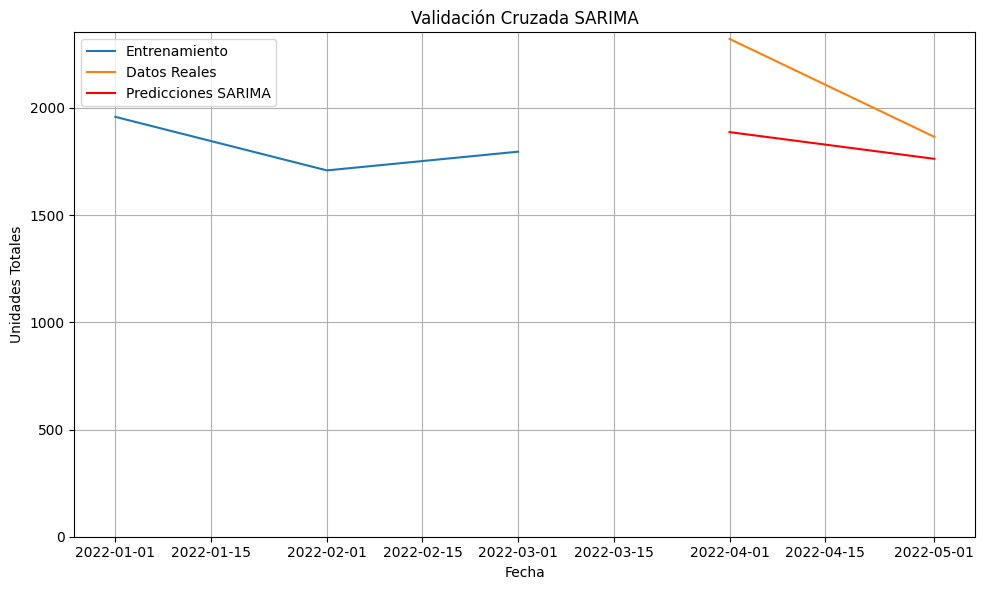

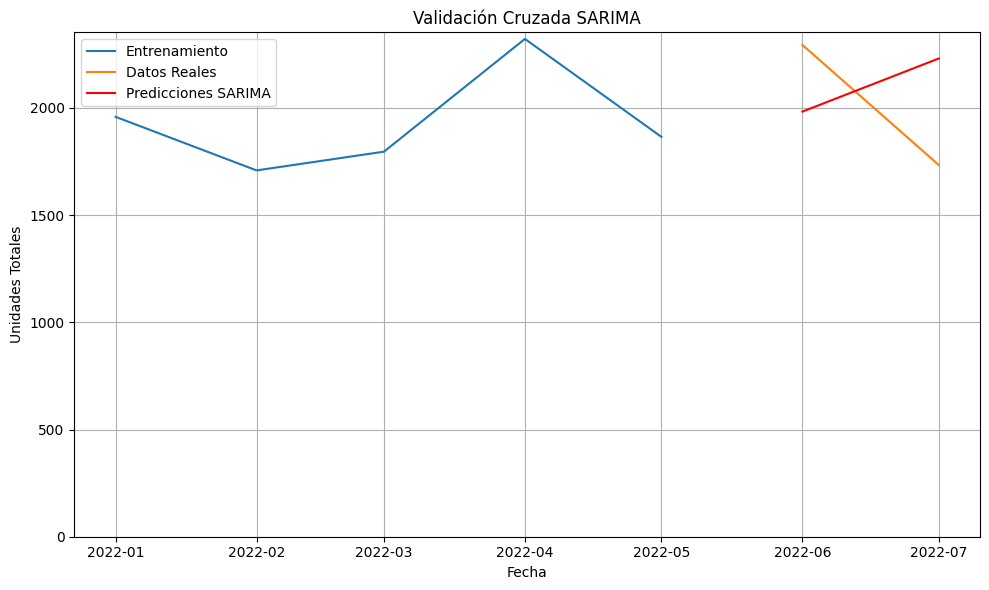

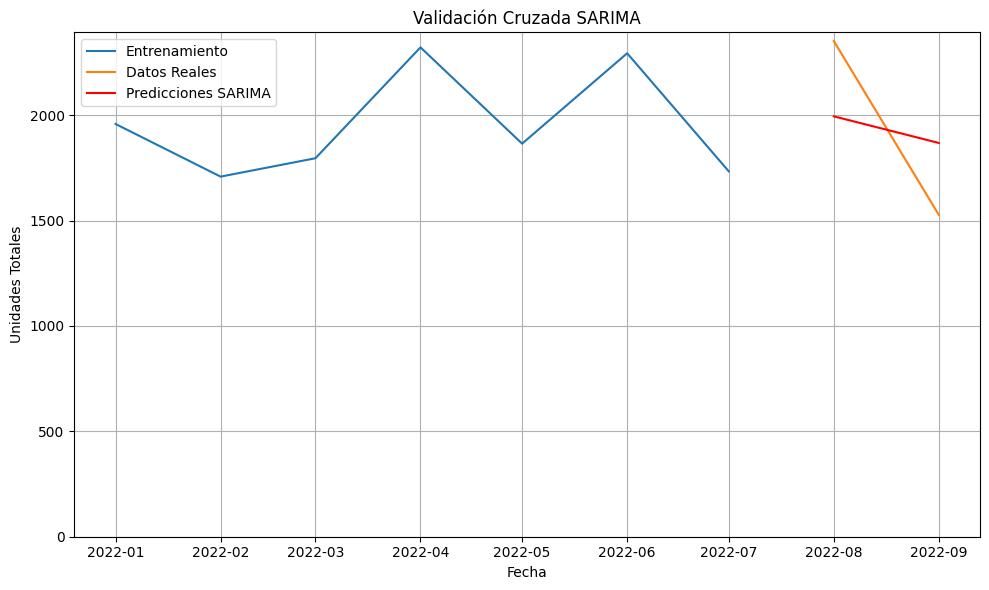

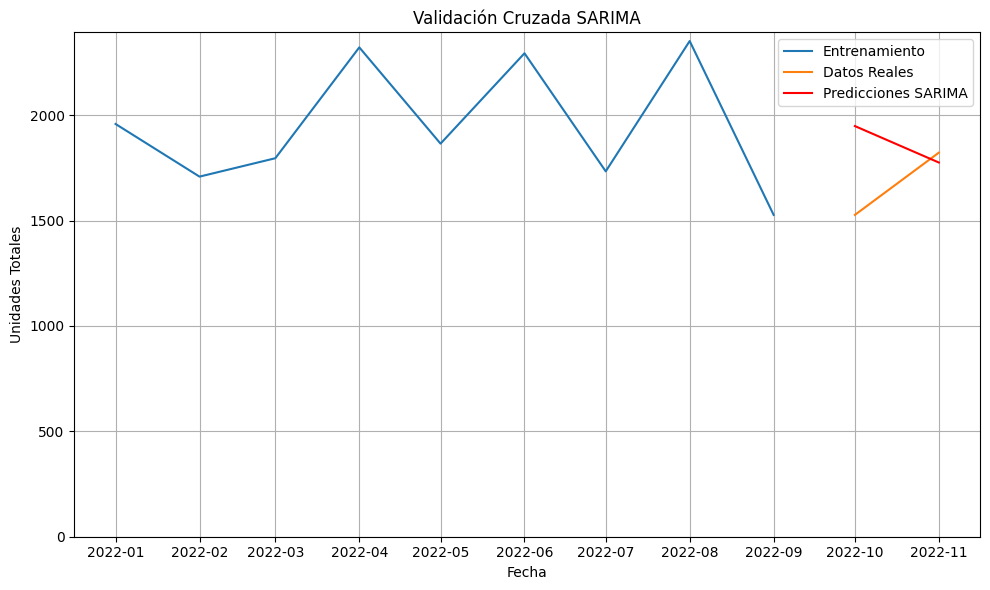

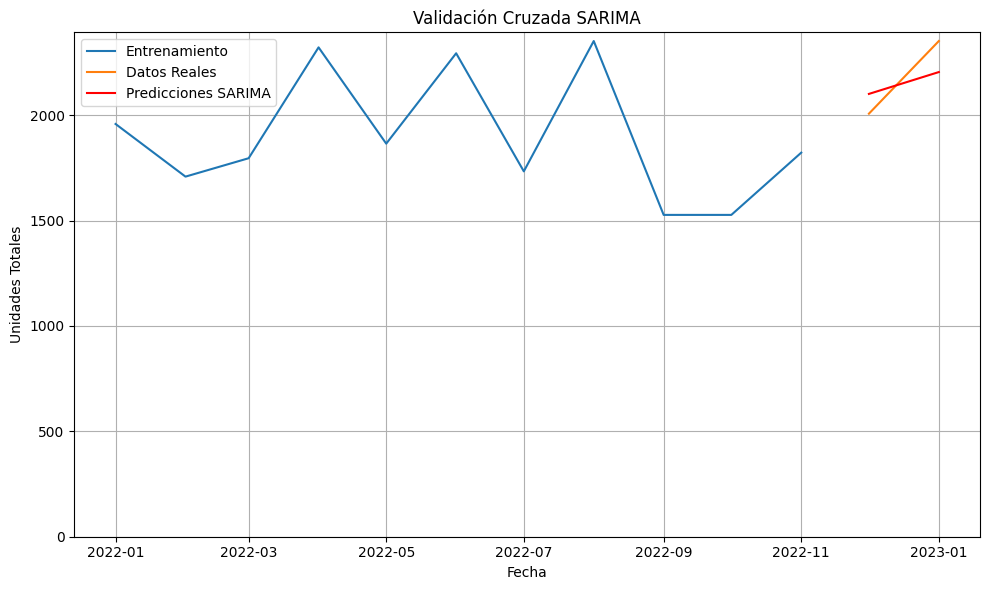

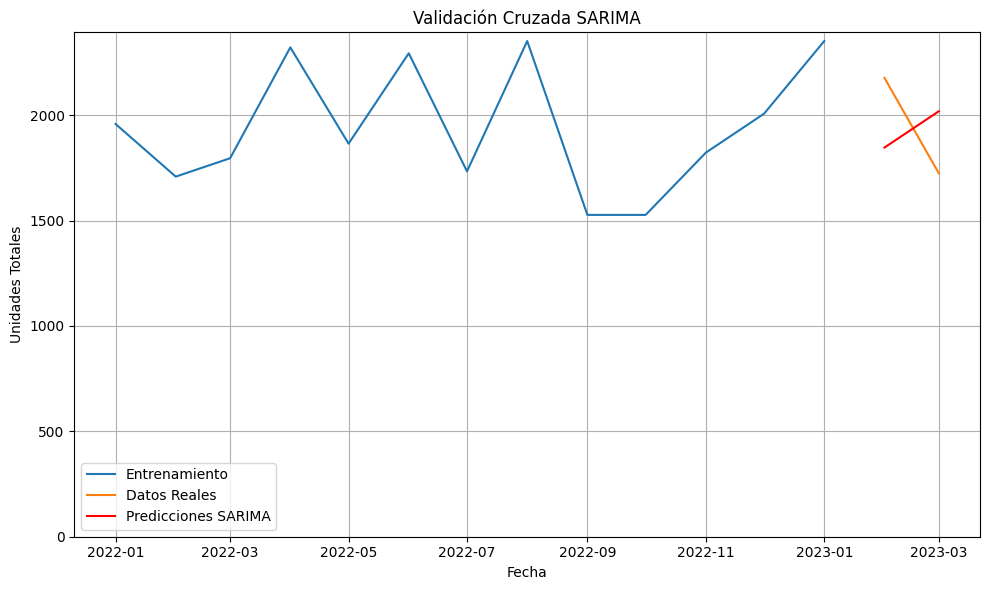

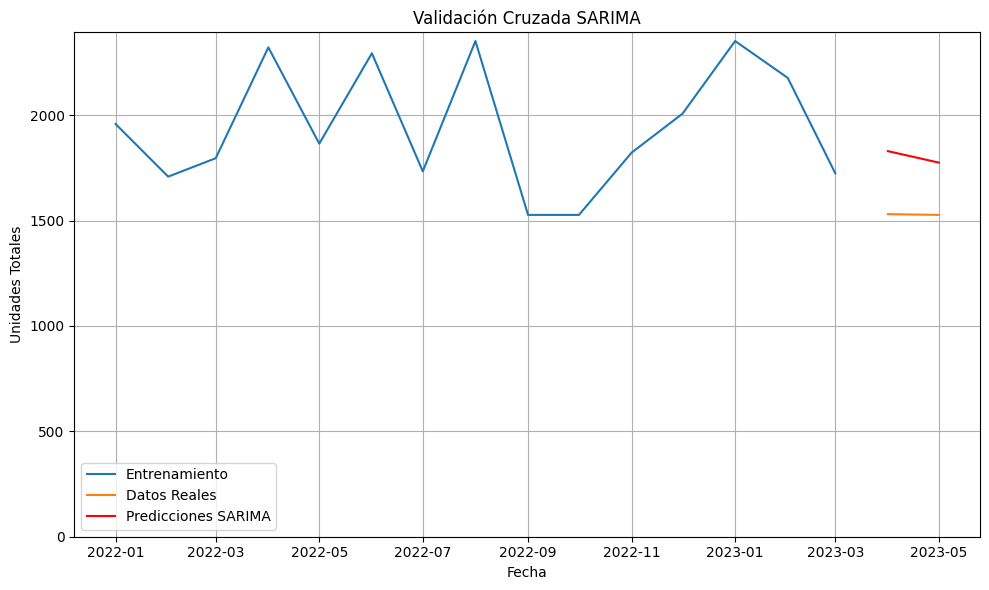

In [38]:
# Crear el objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=7)

# Lista para almacenar los MSE de cada iteración
mse_scores = []

for train_index, test_index in tscv.split(y):
    train, test = y.iloc[train_index], y.iloc[test_index]
    
    # Ajustar el modelo SARIMA
    model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_fit = model.fit(disp=False)
    
    # Hacer predicciones
    predictions = model_fit.forecast(steps=len(test))
    
    # Calcular el MSE y almacenarlo
    mse = mean_squared_error(test, predictions)
    mse_scores.append(mse)

    # Graficar las predicciones vs datos reales
    plt.figure(figsize=(10, 6))
    plt.plot(train.index, train, label='Entrenamiento')
    plt.plot(test.index, test, label='Datos Reales')
    plt.plot(test.index, predictions, color='red', label='Predicciones SARIMA')
    plt.xlabel('Fecha')
    plt.ylabel('Unidades Totales')
    plt.title('Validación Cruzada SARIMA')
    plt.legend()
    plt.grid(True)
    plt.ylim(0)
    plt.tight_layout()
    plt.show()

In [39]:
# Promediar los resultados de MSE
average_mse_1 = np.mean(mse_scores)
print(f'MSE promedio: {average_mse_1}')

mse_1 = mse_scores[-1]
print(f'MSE: {mse_1}')

square_mse_1 = mse_scores[-1]**2
print(f'MSE square: {square_mse_1}')

MSE promedio: 96046.22988011004
MSE: 75472.6107172157
MSE square: 5696114968.4723835


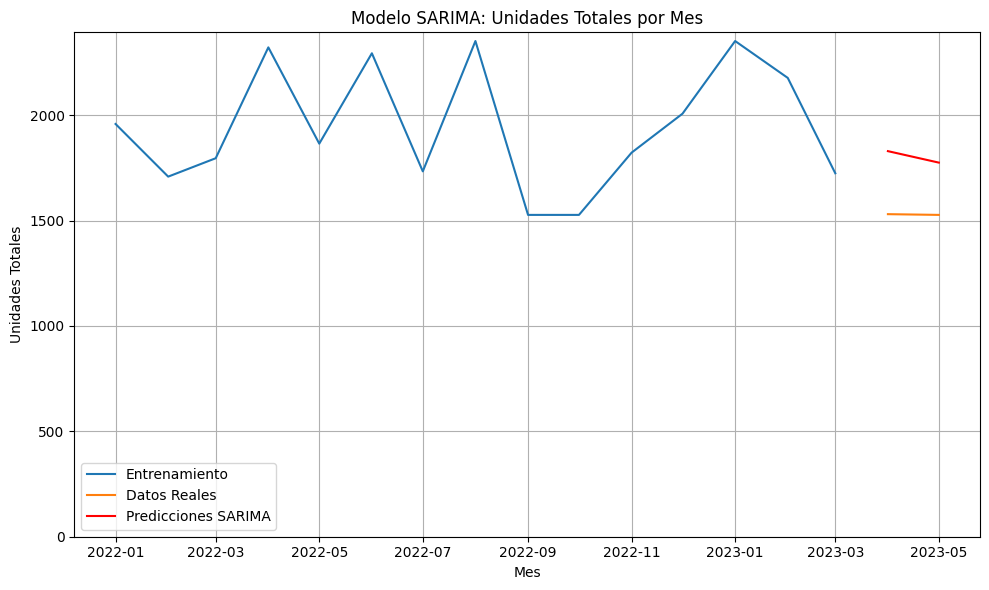

In [40]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Datos Reales')
plt.plot(test.index, predictions, color='red', label='Predicciones SARIMA')

# Personalizar el gráfico
plt.xlabel('Mes')
plt.ylabel('Unidades Totales')
plt.title('Modelo SARIMA: Unidades Totales por Mes')
plt.legend()

# Agregar una cuadrícula
plt.grid(True)

# Establecer el eje y para que comience desde cero
plt.ylim(0)

plt.tight_layout()
plt.show()

## Entrenamiento

In [41]:
# Ajustar el modelo SARIMA
model = SARIMAX(df_pizzas_sd['unidades_total'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=True)

## Resultados

In [62]:
print(f'MSE promedio sin hiperparametrizar: {average_mse_0}')
print(f'MSE sin hiperparametrizar: {mse_0}')
print(f'MSE cuadrado sin hiperparametrizar: {square_mse_0}')
print('')
print(f'MSE promedio hiperparametrizado: {average_mse_1}')
print(f'MSE hiperparametrizado: {mse_1}')
print(f'MSE cuadrado hiperparametrizado: {square_mse_1}')

MSE promedio sin hiperparametrizar: 207504.37857699377
MSE sin hiperparametrizar: 552265.9277607988
MSE cuadrado sin hiperparametrizar: 304997654965.49585

MSE promedio hiperparametrizado: 96046.22988011004
MSE hiperparametrizado: 75472.6107172157
MSE cuadrado hiperparametrizado: 5696114968.4723835


<div style="display: flex; justify-content: space-around;">
    <img src="Images\output.png" alt="SARIMA 1" style="width: 45%;">
    <img src="Images\output_1.png" alt="SARIMA 2" style="width: 45%;">
</div>

In [420]:
# Supongamos que 'model_fit' es tu modelo SARIMA ya entrenado y 'df_pizzas_sd' son tus datos históricos
predictions = model_fit.get_prediction(start=df_pizzas_sd.index[-1] + pd.DateOffset(months=1), end=df_pizzas_sd.index[-1] + pd.DateOffset(months=3), dynamic=True)  # Predicción de 3 meses hacia adelante

# Obtener los valores predichos y los intervalos de confianza
pred_values = predictions.predicted_mean
confidence_intervals = predictions.conf_int(alpha=0.05)

# Supongamos que 'historical_data' es tu serie temporal histórica
historical_data = df_pizzas_sd['unidades_total']  # Debes tener tus datos históricos aquí como una Serie de pandas

# Definir índices para los datos
historical_index = historical_data.index
predicted_index = pd.date_range(start=historical_index[-1], periods=4, freq='ME')[1:]  # Crear índices para las predicciones

# Concatenar los datos históricos con las predicciones para visualización
predicted_data = pd.concat([historical_data, pred_values])

# Calcular los errores
errors = pred_values - historical_data[-3:]  # Calcular el error de los últimos 3 meses

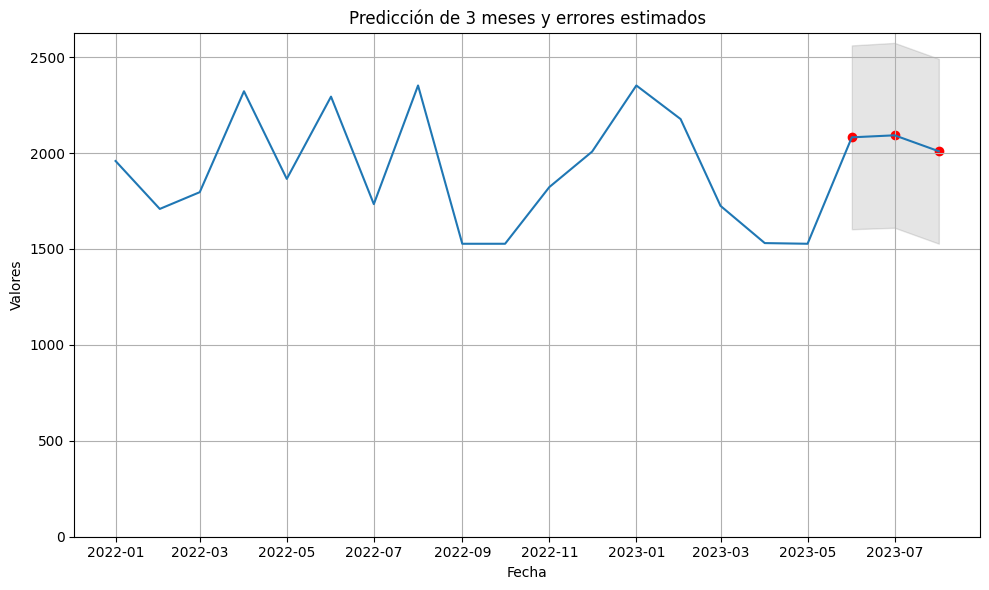

In [421]:
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_data, label='Predicción y Datos Históricos')

# Graficar los intervalos de confianza como una banda sombreada
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='k', alpha=0.1, label='Intervalo de Confianza')

# Resaltar los datos predichos
plt.scatter(pred_values.index, pred_values, color='r', marker='o', label='Predicción')


plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Predicción de 3 meses y errores estimados')

plt.grid(True)
plt.ylim(0)
plt.tight_layout()
plt.show()

## Serialización del Modelo

In [ ]:
joblib.dump(model_fit, 'Model\model_01.pkl')

['Model\\model_01.pkl']